<a href="https://colab.research.google.com/github/andcetera/deep-learning-challenge/blob/main/AlphabetSoupCharity_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 KB 4.0 MB/s eta 0:00:00


In [2]:
# Import dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
import keras_tuner as kt

# Connect to Google Drive to access dataset file
from google.colab import drive
drive.mount('/content/drive')

#  Import and read the charity_data.csv.
import pandas as pd 
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/charity_data.csv")
df.head()

Mounted at /content/drive


,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# Drop the non-beneficial ID columns: 'EIN' and 'NAME'
apps = df.drop(columns=['EIN', 'NAME'])

# Checking number of unique values in remaining columns
apps.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [4]:
app_type = apps['APPLICATION_TYPE'].value_counts()

# Choose a different cutoff value and create a list of application types to be replaced
application_types_to_replace = [app for app in app_type.index if app_type[app] < 10]

# Replace in dataframe
for app in application_types_to_replace:
    apps['APPLICATION_TYPE'] = apps['APPLICATION_TYPE'].replace(app,"Other")

# Check to make sure binning was successful
apps['APPLICATION_TYPE'].value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
T9         156
T13         66
T12         27
T2          16
Other       11
Name: APPLICATION_TYPE, dtype: int64

In [5]:
class_types = apps['CLASSIFICATION'].value_counts()

# Choose a different cutoff value and create a list of classifications to be replaced
classifications_to_replace = [cls for cls in class_types.index if class_types[cls] < 100]

# Replace in dataframe
for cls in classifications_to_replace:
    apps['CLASSIFICATION'] = apps['CLASSIFICATION'].replace(cls,"Other")
    
# Check to make sure binning was successful
apps['CLASSIFICATION'].value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
Other      669
C1700      287
C4000      194
C5000      116
C1270      114
C2700      104
Name: CLASSIFICATION, dtype: int64

In [6]:
# Convert categorical data to numeric with `pd.get_dummies`
affil = pd.get_dummies(apps['AFFILIATION'], drop_first=True, prefix='AFFIL')
use_case = pd.get_dummies(apps['USE_CASE'], drop_first=True, prefix='USE')
org = pd.get_dummies(apps['ORGANIZATION'], drop_first=True, prefix='ORG')
special = pd.get_dummies(apps['SPECIAL_CONSIDERATIONS'], drop_first=True, prefix='SPEC')
app_type = pd.get_dummies(apps['APPLICATION_TYPE'], drop_first=True, prefix='APP')
class_type = pd.get_dummies(apps['CLASSIFICATION'], drop_first=True, prefix='CLASS')
income = pd.get_dummies(apps['INCOME_AMT'], drop_first=True, prefix='INC')
data = apps[['STATUS', 'ASK_AMT', 'IS_SUCCESSFUL']]
data = pd.concat([data, income, affil, use_case, org, special, app_type, class_type], axis=1)
data.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,INC_1-9999,INC_10000-24999,INC_100000-499999,INC_10M-50M,INC_1M-5M,INC_25000-99999,INC_50M+,...,CLASS_C1270,CLASS_C1700,CLASS_C2000,CLASS_C2100,CLASS_C2700,CLASS_C3000,CLASS_C4000,CLASS_C5000,CLASS_C7000,CLASS_Other
0,1,5000,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,108590,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1,5000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,6692,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,142590,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Split the preprocessed data into features and target arrays
y = data['IS_SUCCESSFUL'].values.reshape(-1, 1)
X = data.drop('IS_SUCCESSFUL', axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23)

In [8]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [9]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp:kt.HyperParameters)->tf.keras.Model:
    nn = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=10,
        max_value=100,
        step=10), activation=activation, input_dim=X_train.shape[1]))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 4, 8)):
        nn.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=10,
            max_value=100,
            step=10),
            activation=activation))
    
    # Add the final output layer
    nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn

In [10]:
# Create a tuner with the goal of best accuracy within a short run of 20 epochs
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

In [11]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 01m 10s]
val_accuracy: 0.7286297082901001

Best val_accuracy So Far: 0.731195330619812
Total elapsed time: 00h 33m 21s


In [12]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'relu',
 'first_units': 60,
 'num_layers': 4,
 'units_0': 40,
 'units_1': 20,
 'units_2': 90,
 'units_3': 30,
 'units_4': 80,
 'units_5': 90,
 'units_6': 10,
 'units_7': 40,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0044'}

In [13]:
# Create new model based on hyperparameters of best results from keras tuner
actvn = best_hyper.values['activation']
input = X_train.shape[1]

model = tf.keras.models.Sequential()

# First hidden layer
model.add(tf.keras.layers.Dense(units=best_hyper.values['first_units'], activation=actvn, input_dim=input))

# additional hidden layers
for i in range(best_hyper.values['num_layers']):
  unit = 'units_' + str(i)
  model.add(tf.keras.layers.Dense(units=best_hyper.values[unit], activation=actvn))

# Output layer
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 60)                2820      
                                                                 
 dense_7 (Dense)             (None, 40)                2440      
                                                                 
 dense_8 (Dense)             (None, 20)                820       
                                                                 
 dense_9 (Dense)             (None, 90)                1890      
                                                                 
 dense_10 (Dense)            (None, 30)                2730      
                                                                 
 dense_11 (Dense)            (None, 1)                 31        
                                                                 
Total params: 10,731
Trainable params: 10,731
Non-trai

In [14]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create callback to save weights every 5 epochs
cb = tf.keras.callbacks.ModelCheckpoint(filepath='weights_{epoch:03d}.h5', save_weights_only=True, period=5)

# Create callback to stop if our model doesn't improve loss within 50 epochs & restore to best previous weights
es = callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=50, restore_best_weights=True, verbose=1)

In [15]:
# Train the model with new settings
fit_model = model.fit(X_train_scaled, y_train, epochs=500, callbacks=[cb, es])

Epoch 1/500
804/804 [==============================] - 7s 5ms/step - loss: 0.5732 - accuracy: 0.7189
Epoch 2/500
804/804 [==============================] - 7s 9ms/step - loss: 0.5527 - accuracy: 0.7304
Epoch 3/500
804/804 [==============================] - 6s 7ms/step - loss: 0.5501 - accuracy: 0.7326
Epoch 4/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5489 - accuracy: 0.7324
Epoch 5/500
804/804 [==============================] - 3s 3ms/step - loss: 0.5472 - accuracy: 0.7333
Epoch 6/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5465 - accuracy: 0.7336
Epoch 7/500
804/804 [==============================] - 3s 4ms/step - loss: 0.5452 - accuracy: 0.7345
Epoch 8/500
804/804 [==============================] - 3s 3ms/step - loss: 0.5454 - accuracy: 0.7342
Epoch 9/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5443 - accuracy: 0.7357
Epoch 10/500
804/804 [==============================] - 2s 2ms/step - loss: 0.5443 - accura

In [16]:
# Evaluate the model using the test data
model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 0.5893 - accuracy: 0.7287 - 866ms/epoch - 3ms/step
Loss: 0.5893138647079468, Accuracy: 0.7287463545799255


<Axes: title={'center': 'Training Accuracy'}>

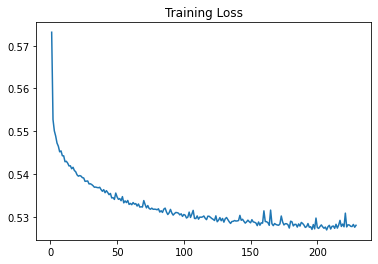

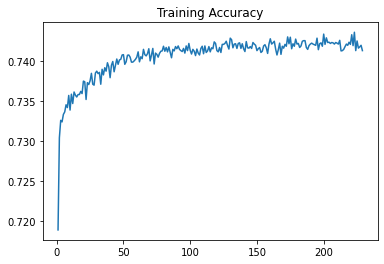

In [17]:
# Create a DataFrame containing training history
hist = pd.DataFrame(fit_model.history)
hist.index += 1

# Plot the training loss & accuracy
hist.plot(y="loss", title="Training Loss", legend=False)
hist.plot(y='accuracy', title="Training Accuracy", legend=False)

In [18]:
# Export our model to HDF5 file
model.save('AlphabetSoupCharity_Optimization.h5')

In [19]:
# Random guess =
1 - sum(y)/len(y)

array([0.46759381])